# K_Neghboors

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# 

## Function

In [38]:
def k_neigbs(elements, k = 5):
    mas = np.random.choice(elements.shape[0], size = k, replace = True)
    centres = np.zeros((k, elements.shape[1]))
    for i in range(k):
        centres[i] = np.array(elements[mas[i]])
    clasts = np.zeros(elements.shape[0])
    old_centres = np.array(centres)
    flag = 1;
    while flag == 1:
        for i in range(elements.shape[0]):
            dif = np.linalg.norm(elements[i]-centres[0], ord = 2);
            min_ind = 0
            for j in range(k):
                tmpdif = np.linalg.norm(elements[i]-centres[j], ord = 2);
                if (tmpdif < dif):
                    min_ind = j
                    dif = tmpdif
            clasts[i] = min_ind
        for i in range(k):
            counts = 0
            summ = np.zeros(elements.shape[1])
            for j in range(elements.shape[0]):
                if clasts[j] == i:
                    counts = counts + 1
                    summ += elements[j]
            if (counts != 0):
                centres[i] = summ/counts
        if np.all(old_centres - centres) or elements.shape[0] <= k:
            flag = 0
        else:
            old_centres = np.array(centres)
    return clasts
        
    

In [76]:
np.random.seed(1)
def go(size, scale = 1, k = 5):
    elements = np.zeros((size, 2))
    for i in range(size):
        #elements[i] = np.random.randint(low = 0, high = 1000, size = 2)
        elements[i] = np.random.random(size = 2)*scale
    k_neigbs(elements, k)
    #plt.scatter(elements[:, 0], elements[:, 1], c=k_neigbs(elements, k = 5))
go(400, 400, 19)

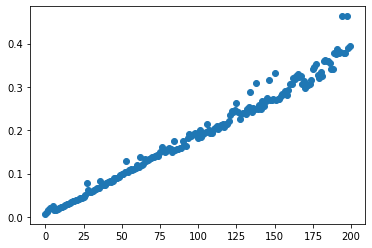

In [58]:
import time


times = np.zeros(200)

start = time.process_time()

for i in range(200):
    go((i+1)*50, scale = (i+1)*50)
    times[i] = time.process_time() - start
    start = time.process_time()

plt.scatter(np.arange(200), times)

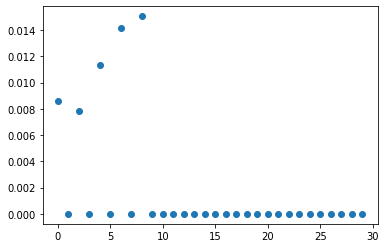

In [96]:
import time

#go(400, 400, 19)
times = np.zeros(30)

start = time.process_time()

for i in range(0, 10, 2):
    #print(i)
    go(200, scale = 200, k = (i+1))
    times[i] = time.process_time() - start
    start = time.process_time()

plt.scatter(np.arange(30), times)

In [75]:
matrix = np.zeros((elements.shape[0], elements.shape[0]))

for i in range(elements.shape[0]):
    tmp = elements[i]
    for j in range(elements.shape[0]):
        matrix[i][j] = np.linalg.norm(elements[j]-tmp, ord = 2)



KeyboardInterrupt: 

In [ ]:
plt.imshow(matrix, 'gray', interpolation=None)